In [1]:
# !pip install dataframe-image

In [2]:
import pandas as pd
import time
import numpy as np
import copy
import glob
import sys, os
import os
import shutil
import dataframe_image as dfi
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.metrics import precision_score, recall_score
import pickle
from sklearn import preprocessing
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment,ACSIncome
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import os
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import pandas as pd
from scipy.stats import multivariate_normal
import torch, random, copy, os
from collections import OrderedDict


In [3]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    # CUDA is not available
    print("CUDA is not available. Running on CPU.")


CUDA is available.


In [4]:
 class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x



In [5]:

path_1="/home/chiragpandav/chirag/FL/FedFB/testing_models/global_model_FF.pt"
path_1_random="/home/chiragpandav/chirag/FL/FedFB/testing_models/global_model_FF_random.pt"
path_2="/home/chiragpandav/chirag/FL/FedFB/testing_models/global_model_FA.pt"
path_3="/home/chiragpandav/chirag/FL/FedFB/testing_models/global_model_FF_OE.pt" 

# Testing on SubGroup
1. BM
2. BW
3. WM
4. WW

In [6]:
os.getcwd()

'/home/chiragpandav/chirag/FL/FedFB'

In [7]:
#Loading Sub_group data
path = "/home/chiragpandav/chirag/FL/FedFB/data_subG/"
client_names = ["WM", "BM", "WW", "BW"]
list_loaded_client_data = []

for i, client_name in enumerate(client_names):
    client_filename = f"{client_name}_client_{i}_data.pkl"
    print("name of subG:: ",client_filename)
    full_path = os.path.join(path, client_filename)

    with open(full_path, "rb") as f:
        client_data = pickle.load(f)
        list_loaded_client_data.append(client_data)

name of subG::  WM_client_0_data.pkl
name of subG::  BM_client_1_data.pkl
name of subG::  WW_client_2_data.pkl
name of subG::  BW_client_3_data.pkl


In [8]:
model=DeepNet()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

# TPR info


In [9]:
# default: 'binary':
# Only report results for the class specified by pos_label. This is applicable only if targets (y_{true, pred}) are binary.

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#:~: text=%27-,binary,-%27 %3A

# We can set: micro, macro, weighted

In [10]:
from sklearn.metrics import recall_score
y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 0, 0, 0, 1, 1]
recall_score(y_true, y_pred, average='binary')

0.5

In [11]:
true_positive = 0
false_negative = 0

for true_label, predicted_label in zip(y_true, y_pred):
    if true_label == 1 and predicted_label == 1:
        true_positive += 1
    elif true_label == 1 and predicted_label == 0:
        false_negative += 1

test_recall = true_positive / (true_positive + false_negative)

print("Recall:", test_recall)

Recall: 0.5


# FAIR FED

In [12]:
model.load_state_dict(torch.load(path_1))
# model.load_state_dict(torch.load(path_1_random))
model.eval()

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
pr_FF=[]
rc_FF=[]
ac_FF=[]
selected_clients = [0, 1, 2, 3]
client_metrics = []

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

all_actaul_y=[]
all_pred_y=[]
temp_list_act=[]
temp_list_pred=[]

for i in range(len(selected_clients)):
    
    for inputs, targets, sens in list_loaded_client_data[i]:
        inputs, targets = inputs.to(device), targets.to(device)

        temp_list_act.append(targets)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        temp_list_pred.append(predicted)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(list_loaded_client_data[i])
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels,average='binary')

    all_actaul_y.append(temp_list_act)
    all_pred_y.append(temp_list_pred)

    temp_list_act=[]
    temp_list_pred=[]

    print("subG name  is ",client_names[i])
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global TPR: {recall:.5%}")
    print("\n")

    data = {
        'SubG': client_names[i],
        'Accuracy': acc,
        'Precision': precision,
        'TPR':recall,
        }
    client_metrics.append(data)

df_ff = pd.DataFrame(client_metrics)
df_ff

subG name  is  WM
Global Testing Accuracy: 83.65012%
Global Precision: 85.11913%
Global TPR: 79.10920%


subG name  is  BM
Global Testing Accuracy: 83.44128%
Global Precision: 83.24742%
Global TPR: 77.88028%


subG name  is  WW
Global Testing Accuracy: 81.45171%
Global Precision: 75.89609%
Global TPR: 79.97170%


subG name  is  BW
Global Testing Accuracy: 81.28574%
Global Precision: 75.40992%
Global TPR: 79.86650%




,SubG,Accuracy,Precision,TPR
0,WM,0.836501,0.851191,0.791092
1,BM,0.834413,0.832474,0.778803
2,WW,0.814517,0.758961,0.799717
3,BW,0.812857,0.754099,0.798665


In [13]:
WM_pred=torch.cat(all_pred_y[0], dim=0).tolist()
BM_pred=torch.cat(all_pred_y[1], dim=0).tolist()
WW_pred=torch.cat(all_pred_y[2], dim=0).tolist()
BW_pred=torch.cat(all_pred_y[3], dim=0).tolist()

WM_labels=torch.cat(all_actaul_y[0], dim=0).tolist()
BM_labels=torch.cat(all_actaul_y[1], dim=0).tolist()
WW_labels=torch.cat(all_actaul_y[2], dim=0).tolist()
BW_labels=torch.cat(all_actaul_y[3], dim=0).tolist()

In [14]:
def prob_indiv_group (WM_labels,BM_labels,WW_labels,BW_labels):
    total_len=len(WM_labels)+len(BM_labels)+len(WW_labels)+len(BW_labels)
    pro_WM=len(WM_labels)/total_len
    pro_BM=len(BM_labels)/total_len
    pro_WW=len(WW_labels)/total_len
    pro_BW=len(BW_labels)/total_len

    print("total length ",total_len)

    print("Sub-G order in list-: WM, BM, WW, BW")
    
    return [pro_WM,pro_BM,pro_WW,pro_BW]    

In [15]:
def prob_predY_individual_grp(data, y=1):
    count_target = sum(row[0] == y for row in data)
    count_other = sum(row[0] != y for row in data)
    probability_target = count_target / len(data)
    print("Count_target: ",count_target,"Other: ",count_other, " probability_target:",probability_target)
    
    return probability_target , count_target

In [16]:
def privacy_measure(grp1,grp2,eps=0.01):
    lower= min(grp1,grp2)
    upper= max(grp1,grp2)
    print("lower/upper", lower/upper)
    privacy_prob=(lower/upper)-np.exp(eps)
    return privacy_prob

In [17]:
def prob_predY_individual_grp_wrp_other_groups(WM_pred,BM_pred,WW_pred,BW_pred):
    prob_preY_WM,count_target_WM=prob_predY_individual_grp(WM_pred)
    prob_preY_BM,count_target_BM=prob_predY_individual_grp(BM_pred)
    prob_preY_WW,count_target_WW=prob_predY_individual_grp(WW_pred)
    prob_preY_BW,count_target_BW=prob_predY_individual_grp(BW_pred)

    print("\n prob_predY_individual_grp function was called")

    #y=1
    total_pred_all_grp=count_target_WM+count_target_BM+count_target_WW+count_target_BW
    #y=1
    prob_grp_given_other_grps=[count_target_WM/total_pred_all_grp,count_target_BM/total_pred_all_grp,count_target_WW/total_pred_all_grp,
                               count_target_BW/total_pred_all_grp]
    print("Sub-G order in list-: WM, BM, WW, BW")
    return prob_grp_given_other_grps

In [18]:
def privacy_semantic_guarantee(grp1_given_pred_y,grp2_given_pred_y,grp1,grp2,eps=0.01):
    temp1=grp1_given_pred_y/grp2_given_pred_y
    temp2=grp1/grp2

    print("temp1 ",temp1,"temp2 ",temp2)

    return temp1/temp2

In [19]:
# data distr probility.
# total labels = total size of particular subgroup

WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob=prob_indiv_group (WM_labels,BM_labels,WW_labels,BW_labels)
WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob

total length  45468
Sub-G order in list-: WM, BM, WW, BW


(0.36911674144453244,
 0.10970352775578429,
 0.39685053224245626,
 0.12432919855722706)

In [20]:
prob_preY_WM,count_target=prob_predY_individual_grp(WM_pred)
prob_preY_BM,count_target=prob_predY_individual_grp(BM_pred)
prob_preY_WW,count_target=prob_predY_individual_grp(WW_pred)
prob_preY_BW,count_target=prob_predY_individual_grp(BW_pred)

Count_target:  7345 Other:  9438  probability_target: 0.43764523625096824
Count_target:  1579 Other:  3409  probability_target: 0.3165597433841219
Count_target:  8206 Other:  9838  probability_target: 0.4547772112613611
Count_target:  2386 Other:  3267  probability_target: 0.4220767733946577


In [21]:
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob=prob_predY_individual_grp_wrp_other_groups(WM_pred,BM_pred,WW_pred,BW_pred)
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob

Count_target:  7345 Other:  9438  probability_target: 0.43764523625096824
Count_target:  1579 Other:  3409  probability_target: 0.3165597433841219
Count_target:  8206 Other:  9838  probability_target: 0.4547772112613611
Count_target:  2386 Other:  3267  probability_target: 0.4220767733946577

 prob_predY_individual_grp function was called
Sub-G order in list-: WM, BM, WW, BW


(0.37635786021725764,
 0.08090797294527567,
 0.4204755072760812,
 0.12225865956138553)

In [22]:
privacy_measure(prob_preY_WM, prob_preY_BM)

lower/upper 0.7233250065644272


-0.28672516051974073

In [23]:
privacy_semantic_guarantee(WW_pred_prob,
                           BW_pred_prob,
                           WW_data_prob,
                           BW_data_prob)

temp1  3.4392288348700757 temp2  3.19193348664426


1.0774750944092515

In [24]:
a=0.2
np.exp(-a),np.exp(a)

(0.8187307530779818, 1.2214027581601699)

# FedAVG

In [25]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

# diff_path="/home/chiragapandav/Downloads/Hiwi/pFedLA_Folktable/temp/my_model/global_model.pt"

model=DeepNet()
model.load_state_dict(torch.load(path_2))
model.eval()
client_metrics=[]

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)


all_actaul_y=[]
all_pred_y=[]
temp_list_act=[]
temp_list_pred=[]

for i in range(len(selected_clients)):
    for inputs, targets, sens in  list_loaded_client_data[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        temp_list_act.append(targets)
        temp_list_pred.append(predicted)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(list_loaded_client_data[i])
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels,average='binary')

    all_actaul_y.append(temp_list_act)
    all_pred_y.append(temp_list_pred)
    
    temp_list_act=[]
    temp_list_pred=[]

    print("subG name  is ",client_names[i])
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global TPR: {recall:.5%}")
    print("\n\n")
    
    data = {
        'SubG': client_names[i],
        'Accuracy': acc,
        'Precision': precision,
        'TPR':recall,
        }
    client_metrics.append(data)

df_FA = pd.DataFrame(client_metrics)
df_FA

subG name  is  WM
Global Testing Accuracy: 80.55771%
Global Precision: 88.04526%
Global TPR: 67.93623%



subG name  is  BM
Global Testing Accuracy: 80.92876%
Global Precision: 85.89897%
Global TPR: 67.56473%



subG name  is  WW
Global Testing Accuracy: 80.26372%
Global Precision: 79.26277%
Global TPR: 69.96986%



subG name  is  BW
Global Testing Accuracy: 80.24325%
Global Precision: 78.79268%
Global TPR: 70.12536%





,SubG,Accuracy,Precision,TPR
0,WM,0.805577,0.880453,0.679362
1,BM,0.809288,0.858990,0.675647
2,WW,0.802637,0.792628,0.699699
3,BW,0.802432,0.787927,0.701254


In [26]:
WM_pred=torch.cat(all_pred_y[0], dim=0).tolist()
BM_pred=torch.cat(all_pred_y[1], dim=0).tolist()
WW_pred=torch.cat(all_pred_y[2], dim=0).tolist()
BW_pred=torch.cat(all_pred_y[3], dim=0).tolist()

In [27]:
prob_preY_WM,count_target=prob_predY_individual_grp(WM_pred)
prob_preY_BM,count_target=prob_predY_individual_grp(BM_pred)
prob_preY_WW,count_target=prob_predY_individual_grp(WW_pred)
prob_preY_BW,count_target=prob_predY_individual_grp(BW_pred)

Count_target:  6098 Other:  10685  probability_target: 0.36334385985818984
Count_target:  1405 Other:  3583  probability_target: 0.28167602245388934
Count_target:  6848 Other:  11196  probability_target: 0.37951673686544
Count_target:  2049 Other:  3604  probability_target: 0.3624624093401734


In [28]:
WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob=prob_indiv_group (WM_labels,BM_labels,WW_labels,BW_labels)
WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob

total length  45468
Sub-G order in list-: WM, BM, WW, BW


(0.36911674144453244,
 0.10970352775578429,
 0.39685053224245626,
 0.12432919855722706)

In [29]:
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob=prob_predY_individual_grp_wrp_other_groups(WM_pred,BM_pred,WW_pred,BW_pred)
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob

Count_target:  6098 Other:  10685  probability_target: 0.36334385985818984
Count_target:  1405 Other:  3583  probability_target: 0.28167602245388934
Count_target:  6848 Other:  11196  probability_target: 0.37951673686544
Count_target:  2049 Other:  3604  probability_target: 0.3624624093401734

 prob_predY_individual_grp function was called
Sub-G order in list-: WM, BM, WW, BW


(0.3718292682926829,
 0.08567073170731708,
 0.4175609756097561,
 0.1249390243902439)

In [30]:
privacy_semantic_guarantee(WW_pred_prob,
                           BW_pred_prob,
                           WW_pred_prob,
                           BW_data_prob)

temp1  3.3421181063933623 temp2  3.3585109568413922


0.9951190123662877

In [31]:
privacy_measure(prob_preY_WW, prob_preY_BW)

lower/upper 0.9550630423677116


-0.05498712471645639

# our experiement

In [32]:
model=DeepNet()
model.load_state_dict(torch.load(path_3))
model.eval()

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
pr_FF=[]
rc_FF=[]
ac_FF=[]
selected_clients = [0, 1, 2, 3]
client_metrics = []

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

all_actaul_y=[]
all_pred_y=[]
temp_list_act=[]
temp_list_pred=[]

for i in range(len(selected_clients)):
    
    for inputs, targets, sens in list_loaded_client_data[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        temp_list_act.append(targets)
        temp_list_pred.append(predicted)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(list_loaded_client_data[i])
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels,average='binary')
    
    all_actaul_y.append(temp_list_act)
    all_pred_y.append(temp_list_pred)
    
    temp_list_act=[]
    temp_list_pred=[]
    
    print("subG name  is ",client_names[i])
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global TPR: {recall:.5%}")
    print("\n")

    data = {
        'SubG': client_names[i],
        'Accuracy': acc,
        'Precision': precision,
        'TPR':recall,
        }
    client_metrics.append(data)

df_ff_o = pd.DataFrame(client_metrics)
df_ff_o


subG name  is  WM
Global Testing Accuracy: 82.71465%
Global Precision: 86.52161%
Global TPR: 74.97153%


subG name  is  BM
Global Testing Accuracy: 82.66042%
Global Precision: 83.95382%
Global TPR: 74.70385%


subG name  is  WW
Global Testing Accuracy: 81.35125%
Global Precision: 77.53461%
Global TPR: 76.49013%


subG name  is  BW
Global Testing Accuracy: 81.23735%
Global Precision: 76.88838%
Global TPR: 76.78407%




,SubG,Accuracy,Precision,TPR
0,WM,0.827147,0.865216,0.749715
1,BM,0.826604,0.839538,0.747038
2,WW,0.813512,0.775346,0.764901
3,BW,0.812374,0.768884,0.767841


In [33]:
WM_pred=torch.cat(all_pred_y[0], dim=0).tolist()
BM_pred=torch.cat(all_pred_y[1], dim=0).tolist()
WW_pred=torch.cat(all_pred_y[2], dim=0).tolist()
BW_pred=torch.cat(all_pred_y[3], dim=0).tolist()

In [34]:
prob_preY_WM,count_target=prob_predY_individual_grp(WM_pred)
prob_preY_BM,count_target=prob_predY_individual_grp(BM_pred)
prob_preY_WW,count_target=prob_predY_individual_grp(WW_pred)
prob_preY_BW,count_target=prob_predY_individual_grp(BW_pred)

Count_target:  6848 Other:  9935  probability_target: 0.4080319370791873
Count_target:  1640 Other:  3348  probability_target: 0.32878909382518046
Count_target:  7550 Other:  10494  probability_target: 0.4184216360008867
Count_target:  2364 Other:  3289  probability_target: 0.4181850344949584


In [35]:
# data distr probility.
# total labels = total size of particular subgroup

WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob=prob_indiv_group (WM_labels,BM_labels,WW_labels,BW_labels)
WM_data_prob,BM_data_prob,WW_data_prob,BW_data_prob

total length  45468
Sub-G order in list-: WM, BM, WW, BW


(0.36911674144453244,
 0.10970352775578429,
 0.39685053224245626,
 0.12432919855722706)

In [36]:
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob=prob_predY_individual_grp_wrp_other_groups(WM_pred,BM_pred,WW_pred,BW_pred)
WM_pred_prob,BM_pred_prob,WW_pred_prob,BW_pred_prob

Count_target:  6848 Other:  9935  probability_target: 0.4080319370791873
Count_target:  1640 Other:  3348  probability_target: 0.32878909382518046
Count_target:  7550 Other:  10494  probability_target: 0.4184216360008867
Count_target:  2364 Other:  3289  probability_target: 0.4181850344949584

 prob_predY_individual_grp function was called
Sub-G order in list-: WM, BM, WW, BW


(0.3721334637539398,
 0.08912074774481035,
 0.41028149114226714,
 0.1284642973589827)

In [37]:
privacy_semantic_guarantee(BW_pred_prob,
                           BM_pred_prob,
                           BW_pred_prob,
                           BM_data_prob)

temp1  1.441463414634146 temp2  1.171013366543349


1.2309538522938674

In [38]:
privacy_measure(prob_preY_WW, prob_preY_BW)

lower/upper 0.9994345380698053


-0.010615629014362638

In [39]:
0.32878909382518046/0.4080319370791873

0.8057925469725472

In [40]:
dummy_val=0.2
np.exp(-dummy_val), np.exp(dummy_val)

(0.8187307530779818, 1.2214027581601699)

# classical model

In [41]:
 
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


In [43]:
temp_path_data="/home/chiragpandav/chirag/FL/FedFB/"

with open(temp_path_data+"/Normal_training_data.pkl", "rb") as f:
    nor_trainData = pickle.load(f)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=DeepNet()

model = model.to(device)
criterion = criterion.to(device)

In [45]:
# num_epochs=10
# for epoch in range(num_epochs):
#     # Set the model to training mode
#     model.train()

#     for inputs, labels, sens in nor_trainData:
        
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs).to(device)
#         loss = criterion(outputs, labels.float())
#         loss.backward()
#         optimizer.step()

In [46]:
torch.save(model.state_dict(), "normal_model.pth")

In [47]:
size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

model=DeepNet()
model.load_state_dict(torch.load("normal_model.pth"))
model.eval()

client_metrics=[]
# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in list_loaded_client_data[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(list_loaded_client_data[i])
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels,average='binary')

    print("subG name  is ",client_names[i])
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")

    data = {
        'SubG': client_names[i],
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_CD = pd.DataFrame(client_metrics)
df_CD

subG name  is  WM
Global Testing Accuracy: 38.90246%
Global Precision: 11.97024%
Global Recall: 4.68177%



subG name  is  BM
Global Testing Accuracy: 40.60907%
Global Precision: 11.83885%
Global Recall: 5.51420%



subG name  is  WW
Global Testing Accuracy: 44.66909%
Global Precision: 10.91401%
Global Recall: 4.95786%



subG name  is  BW
Global Testing Accuracy: 44.72816%
Global Precision: 11.76135%
Global Recall: 5.59505%





,SubG,Accuracy,Precision,Recall
0,WM,0.389025,0.119702,0.046818
1,BM,0.406091,0.118388,0.055142
2,WW,0.446691,0.109140,0.049579
3,BW,0.447282,0.117614,0.055951


KeyError: 'Recall'

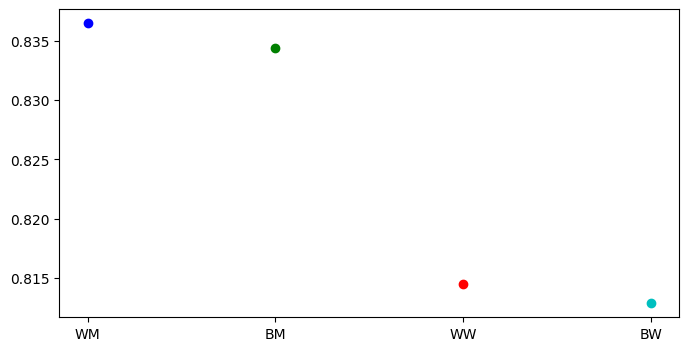

In [48]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_ff['SubG']):
    ax.scatter(client, df_ff['Accuracy'][i], c=colors[i], marker='o', label=f'subG_{client} - Accuracy')

for i, client in enumerate(df_ff['SubG']):
    ax.scatter(client, df_ff['Recall'][i], c=colors[i], marker='x', label=f'subG_{client} - TPR')

ax.set_xlabel('SubG')
ax.set_ylabel('Value')
ax.set_title('FairFed: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

In [ ]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_FA['SubG']):
    ax.scatter(client, df_FA['Accuracy'][i], c=colors[i], marker='o', label=f'SubG_{client} - Accuracy')

for i, client in enumerate(df_FA['SubG']):
    ax.scatter(client, df_FA['Recall'][i], c=colors[i], marker='x', label=f'SubG_{client} - TPR')

ax.set_xlabel('SubG')
ax.set_ylabel('Value')
ax.set_title('FedAVG: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

In [ ]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_ff_o['SubG']):
    ax.scatter(client, df_ff_o['Accuracy'][i], c=colors[i], marker='o', label=f'SubG_{client} - Accuracy')

for i, client in enumerate(df_ff_o['SubG']):
    ax.scatter(client, df_ff_o['Recall'][i], c=colors[i], marker='x', label=f'SubG_{client} - TPR')

ax.set_xlabel('SubG')
ax.set_ylabel('Value')
ax.set_title('FairFed_experimental: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

In [ ]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_CD['SubG']):
    ax.scatter(client, df_CD['Accuracy'][i], c=colors[i], marker='o', label=f'SubG_{client} - Accuracy')

for i, client in enumerate(df_CD['SubG']):
    ax.scatter(client, df_CD['Recall'][i], c=colors[i], marker='x', label=f'SubG_{client} - TPR')

ax.set_xlabel('SubG')
ax.set_ylabel('Value')
ax.set_title('Classical_DL: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Data
client_names = ['Client 1', 'Client 2', 'Client 3', 'Client 4']
data_sizes = [27424, 28685, 39815, 40480]

# Dictionary to map old names to new names
name_mapping = {
    'Client 1': 'WM_BM_BW',
    'Client 2': 'WW_BW_BM',
    'Client 3': 'BM_WM_WW',
    'Client 4': 'WW_WM_BW'
}

client_names = [name_mapping[name] for name in client_names]

# Create a bar chart
plt.bar(client_names, data_sizes, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Client')
plt.ylabel('Data Size')
plt.title('Data Size for Each Client')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


# individual client performance

Generated using random split (fairFed)

In [ ]:
# these are generated with fairfed

In [50]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

model=DeepNet()

models_directory = "/home/chiragpandav/chirag/FL/FedFB/models/"

client_metrics=[]
# Assuming model and criterion are already defined and loaded onto the GPU

criterion = criterion.to(device)

for i in range(len(selected_clients)):
    model_path = os.path.join(models_directory, f"client_{i}_model.pth")  
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    print("client::",i)
    model = model.to(device)
    for inputs, targets, sens in list_loaded_client_data[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(list_loaded_client_data[i])
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_CD = pd.DataFrame(client_metrics)
df_CD

client:: 0
Global Testing Accuracy: 80.66496%
Global Precision: 86.61950%
Global Recall: 69.70771%



client:: 1
Global Testing Accuracy: 80.54292%
Global Precision: 83.52510%
Global Recall: 69.25254%



client:: 2
Global Testing Accuracy: 79.19377%
Global Precision: 74.49763%
Global Recall: 74.57095%



client:: 3
Global Testing Accuracy: 79.15237%
Global Precision: 74.45878%
Global Recall: 73.91328%





,Client ID,Accuracy,Precision,Recall
0,0,0.806650,0.866195,0.697077
1,1,0.805429,0.835251,0.692525
2,2,0.791938,0.744976,0.745710
3,3,0.791524,0.744588,0.739133


In [ ]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('individual client performance: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()